In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import shutil

import librosa as lb
import soundfile as sf
import IPython.display as ipd
import librosa.display

import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from numba import jit, cuda

cycle_time = 6

In [6]:
patient_data = pd.read_csv(
    '.\Respiratory_Sound_Database\patient_diagnosis.csv',
    names=['pid','disease']
)

In [7]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [44]:
patient_data[patient_data["pid"] == 103].iloc[0].disease

'Asthma'

### Augmentation

In [51]:
path = './Respiratory_Sound_Database/audio_and_txt_files_v2/'
file_names = [s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
file_names[:9]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200',
 '104_1b1_Ar_sc_Litt3200',
 '104_1b1_Ll_sc_Litt3200',
 '104_1b1_Lr_sc_Litt3200',
 '104_1b1_Pl_sc_Litt3200']

In [119]:
diseases_types = ['Asthma',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Healthy',
 'LRTI',
 'Pneumonia',
 'URTI']

@jit(forceobj=True)
def white_noise(data):
    # Adding white noise
    wn = np.random.randn(len(data))
    k = random.randint(1, 9) / 1000
    
    data_wn = data + k * wn
    return data_wn

@jit(forceobj=True)
def shift_sound(data, sr):
    # Shifting the sound
    n = int(sr * cycle_time * random.randint(1, 6))
    
    data_roll = np.roll(data, n)
    
    return data_roll

@jit(forceobj=True)
def augment_n_times(file_name, n):
    wav_file_loc = path + file_name + '.wav'
    txt_file_loc = path + file_name + '.txt'
    
    sound, sample_rate = lb.load(wav_file_loc)
    
    for i in range(n):
        sound_wn = white_noise(sound)
        
        new_wav_path = f"{path}{file_name}_WN{i}.wav"
        sf.write(file = new_wav_path, data = sound_wn, samplerate = sample_rate)
        new_txt_path = f"{path}{file_name}_WN{i}.txt"
        shutil.copyfile(txt_file_loc, new_txt_path)
        
        if i % 2 == 1:
            sound_roll = shift_sound(sound, sample_rate)
        else: sound_roll = shift_sound(sound_wn, sample_rate)
        
        new_wav_path = f"{path}{file_name}_ROLL{i}.wav"
        sf.write(file = new_wav_path, data = sound_roll, samplerate = sample_rate)
        new_txt_path = f"{path}{file_name}_ROLL{i}.txt"
        shutil.copyfile(txt_file_loc, new_txt_path)

        
path = './Respiratory_Sound_Database/audio_and_txt_files_v2/'
file_names = [s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
        
for file_name in file_names:
    patient_id = int(file_name.split("_")[0])
    patient_disease = patient_data[patient_data["pid"] == patient_id].iloc[0].disease
    
    if patient_disease == "Asthma" or patient_disease == "LRTI":
        augment_n_times(file_name, 8)
    if patient_disease == "Bronchiolitis" or patient_disease == "URTI":
        augment_n_times(file_name, 2)
    if patient_disease == "Pneumonia" or patient_disease == "Healthy" or patient_disease == "Bronchiectasis":
        augment_n_times(file_name, 1)

In [3]:
path = './Respiratory_Sound_Database/audio_and_txt_files_v2/'
file_names = [s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
file_names[:9]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Al_sc_Meditron_ROLL0',
 '101_1b1_Al_sc_Meditron_ROLL1',
 '101_1b1_Al_sc_Meditron_WN0',
 '101_1b1_Al_sc_Meditron_WN1',
 '101_1b1_Pr_sc_Meditron',
 '101_1b1_Pr_sc_Meditron_ROLL0',
 '101_1b1_Pr_sc_Meditron_ROLL1',
 '101_1b1_Pr_sc_Meditron_WN0']

In [142]:
files_data = []
for file in file_names:
    data = pd.read_csv(path + file + '.txt', sep = '\t', names = ['start', 'end', 'crackles', 'weezels'])
    data['pid'] = file.split('_')[0]
    data['filename'] = file
    files_data.append(data)

files_df = pd.concat(files_data)
files_df.reset_index(drop = True, inplace = True)
files_df

,start,end,crackles,weezels,pid,filename
0,0.036,0.579,0,0,101,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101,101_1b1_Al_sc_Meditron
3,3.893,5.793,0,0,101,101_1b1_Al_sc_Meditron
4,5.793,7.521,0,0,101,101_1b1_Al_sc_Meditron
...,...,...,...,...,...,...
10535,11.721,13.693,1,0,226,226_1b1_Pl_sc_LittC2SE_WN0
10536,13.693,15.536,0,0,226,226_1b1_Pl_sc_LittC2SE_WN0
10537,15.536,17.493,0,0,226,226_1b1_Pl_sc_LittC2SE_WN0
10538,17.493,19.436,1,0,226,226_1b1_Pl_sc_LittC2SE_WN0


In [143]:
patient_data.pid = patient_data.pid.astype('int32')
files_df.pid = files_df.pid.astype('int32')

In [144]:
data = pd.merge(files_df, patient_data, on = 'pid')
data

,start,end,crackles,weezels,pid,filename,disease
0,0.036,0.579,0,0,101,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,101_1b1_Al_sc_Meditron,URTI
...,...,...,...,...,...,...,...
10535,11.721,13.693,1,0,226,226_1b1_Pl_sc_LittC2SE_WN0,Pneumonia
10536,13.693,15.536,0,0,226,226_1b1_Pl_sc_LittC2SE_WN0,Pneumonia
10537,15.536,17.493,0,0,226,226_1b1_Pl_sc_LittC2SE_WN0,Pneumonia
10538,17.493,19.436,1,0,226,226_1b1_Pl_sc_LittC2SE_WN0,Pneumonia


D:\Program\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

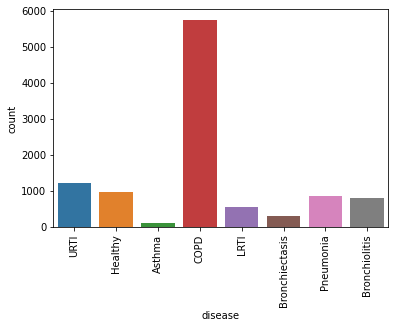

In [145]:
sns.countplot(data.disease)
plt.xticks(rotation = 90)

In [146]:
data.to_csv('csv_data/data_v2.csv', index = False)

In [149]:
general = data.copy()
for index, row in general.iterrows():
    if row["disease"] == "COPD" and random.randint(1, 10) > 3:
        general = general.drop(index)
general.reset_index(drop = True, inplace = True)
general

,start,end,crackles,weezels,pid,filename,disease
0,0.036,0.579,0,0,101,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,101_1b1_Al_sc_Meditron,URTI
...,...,...,...,...,...,...,...
6479,11.721,13.693,1,0,226,226_1b1_Pl_sc_LittC2SE_WN0,Pneumonia
6480,13.693,15.536,0,0,226,226_1b1_Pl_sc_LittC2SE_WN0,Pneumonia
6481,15.536,17.493,0,0,226,226_1b1_Pl_sc_LittC2SE_WN0,Pneumonia
6482,17.493,19.436,1,0,226,226_1b1_Pl_sc_LittC2SE_WN0,Pneumonia


D:\Program\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

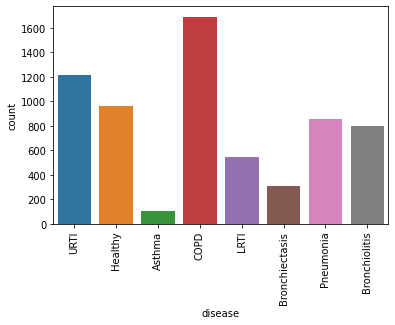

In [150]:
sns.countplot(general.disease)
plt.xticks(rotation=90)

### Processing

In [151]:
os.makedirs('processed_audio_files_v2')

In [152]:
general.head()

,start,end,crackles,weezels,pid,filename,disease
0,0.036,0.579,0,0,101,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,101_1b1_Al_sc_Meditron,URTI


In [154]:
def getBreathCycle(raw_data, start, end, sr = 22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data = numpy array of audio sample
    start = time
    end = time
    sr = sampling_rate
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind:end_ind]

@jit(forceobj=True)
def processing(data, path='./Respiratory_Sound_Database/audio_and_txt_files_v2/'):
    i, count = 0, 0

    for index, row in general.iterrows():
        start = row['start']
        end = row['end']
        filename = row['filename']

        if end - start > cycle_time:
            end = start + cycle_time

        audio_file_loc = path + filename + '.wav'
        audio_arr, sample_rate = lb.load(audio_file_loc)
        breath_cycle = getBreathCycle(audio_arr, start, end, sr = sample_rate)

        required_length = cycle_time * sample_rate
        if len(breath_cycle) < required_length:
            output_data = lb.util.pad_center(data = breath_cycle, size = required_length)
        else:
            output_data = breath_cycle

        if index != 0:
            if data.iloc[index - 1]['filename'] == filename:
                i += 1
            else:
                i = 0
        filename = filename + '_' + str(i) + '.wav'
        save_path = 'processed_audio_files_v2/' + filename
        
        sf.write(file = save_path, data = output_data, samplerate = sample_rate)
        count += 1
    print('Total Files Processed: ', count)

In [155]:
processing(general)

Total Files Processed:  6484


### Train & Validation sets

In [4]:
path = 'processed_audio_files_v2/'
length = len(os.listdir(path))
index = range(length)
files_df = pd.DataFrame(index = index, columns = ['pid', 'filename'])
i = 0
for file in os.listdir(path):
    files_df.iloc[i]['pid'] = file.split('_')[0]
    files_df.iloc[i]['filename'] = file
    i += 1
files_df.head()

,pid,filename
0,101,101_1b1_Al_sc_Meditron_0.wav
1,101,101_1b1_Al_sc_Meditron_1.wav
2,101,101_1b1_Al_sc_Meditron_10.wav
3,101,101_1b1_Al_sc_Meditron_11.wav
4,101,101_1b1_Al_sc_Meditron_2.wav


In [8]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [9]:
files_df.pid = files_df.pid.astype('int64') 
data = pd.merge(files_df, patient_data, on='pid')
data

,pid,filename,disease
0,101,101_1b1_Al_sc_Meditron_0.wav,URTI
1,101,101_1b1_Al_sc_Meditron_1.wav,URTI
2,101,101_1b1_Al_sc_Meditron_10.wav,URTI
3,101,101_1b1_Al_sc_Meditron_11.wav,URTI
4,101,101_1b1_Al_sc_Meditron_2.wav,URTI
...,...,...,...
6479,226,226_1b1_Pl_sc_LittC2SE_WN0_5.wav,Pneumonia
6480,226,226_1b1_Pl_sc_LittC2SE_WN0_6.wav,Pneumonia
6481,226,226_1b1_Pl_sc_LittC2SE_WN0_7.wav,Pneumonia
6482,226,226_1b1_Pl_sc_LittC2SE_WN0_8.wav,Pneumonia


In [17]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,Ytrain,Yval = train_test_split(data, data.disease, stratify=data.disease, random_state=12, test_size=0.2)

In [19]:
train = Xtrain.copy()
val = Xval.copy()
ytrain = train.disease
yval = val.disease
ytrain

6320           Healthy
5486     Bronchiolitis
2485           Healthy
6168              COPD
3977    Bronchiectasis
             ...      
3441     Bronchiolitis
5901              COPD
6194         Pneumonia
171             Asthma
1919         Pneumonia
Name: disease, Length: 5187, dtype: object

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
yval = le.transform(yval)

In [59]:
ytrain, ytrain.size

(array([4, 2, 4, ..., 6, 0, 6]), 5187)

In [60]:
yval, yval.size

(array([3, 3, 6, ..., 2, 7, 7]), 1297)

In [23]:
le.inverse_transform(ytrain)

array(['Healthy', 'Bronchiolitis', 'Healthy', ..., 'Pneumonia', 'Asthma',
       'Pneumonia'], dtype=object)

In [24]:
list(le.classes_)

['Asthma',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Healthy',
 'LRTI',
 'Pneumonia',
 'URTI']

### Features

In [31]:
sound_arr, sample_rate = lb.load("D:\\ai\\processed_audio_files_v2\\103_2b2_Ar_mc_LittC2SE_2.wav")
mfcc = lb.feature.mfcc(y = sound_arr, sr = sample_rate)
cstft = lb.feature.chroma_stft(y = sound_arr, sr = sample_rate)
mSpec = lb.feature.melspectrogram(y = sound_arr, sr = sample_rate)

In [32]:
mfcc.shape

(20, 259)

In [33]:
cstft.shape

(12, 259)

In [34]:
mSpec.shape

(128, 259)

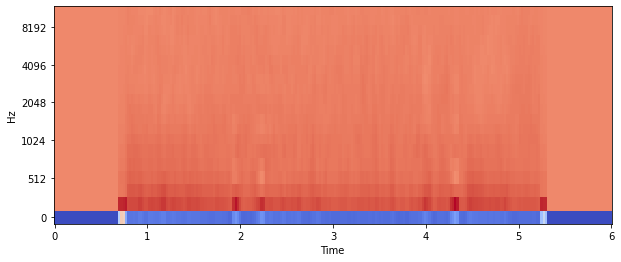

In [62]:
plt.figure(figsize = (10, 4))
librosa.display.specshow(mfcc, sr = sample_rate,  y_axis = 'mel', x_axis = 'time')

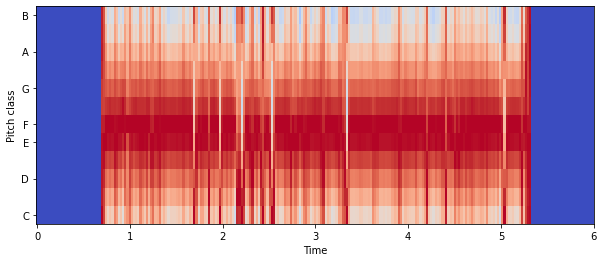

In [64]:
plt.figure(figsize = (10, 4))
librosa.display.specshow(cstft, x_axis = 'time', y_axis = 'chroma', cmap = 'coolwarm')

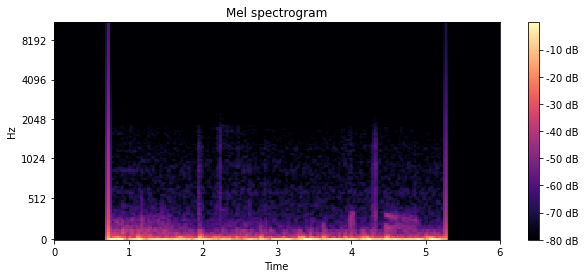

In [66]:
fig, ax = plt.subplots(figsize = (10, 4))
M_db = librosa.power_to_db(mSpec, ref = np.max)
img = librosa.display.specshow(M_db, y_axis = 'mel', x_axis = 'time', ax = ax)
ax.set(title = 'Mel spectrogram')
fig.colorbar(img, ax = ax, format = "%+2.f dB")

In [4]:
@jit(forceobj=True)
def getFeatures(path):
    sound_arr, sample_rate = lb.load(path)
    mfcc = lb.feature.mfcc(y = sound_arr, sr = sample_rate)
    cstft = lb.feature.chroma_stft(y = sound_arr, sr = sample_rate)
    mSpec = lb.feature.melspectrogram(y = sound_arr, sr = sample_rate)
    return mfcc, cstft, mSpec

In [28]:
dir_path = 'processed_audio_files_v2/'

mfcc,cstft,mSpec = [],[],[]
for i, row in val.iterrows():
    path = dir_path + row['filename']
    a,b,c = getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

mfcc_val = np.array(mfcc)
cstft_val = np.array(cstft)
mSpec_val = np.array(mSpec)

D:\Program\miniconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [29]:
mfcc,cstft,mSpec = [],[],[]
for i, row in train.iterrows():
    path = dir_path + row['filename']
    a,b,c = getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train = np.array(mfcc)
cstft_train = np.array(cstft)
mSpec_train = np.array(mSpec)

In [36]:
mfcc_val.shape

(1297, 20, 259)

In [37]:
mfcc_train.shape

(5187, 20, 259)

In [39]:
mfcc_train[0,0]

array([-608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.4094 ,
       -608.4094 , -608.4094 , -608.4094 , -608.4094 , -608.40

### Model

In [40]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                              patience = 3, min_lr = 0.00001, mode = 'min')
]

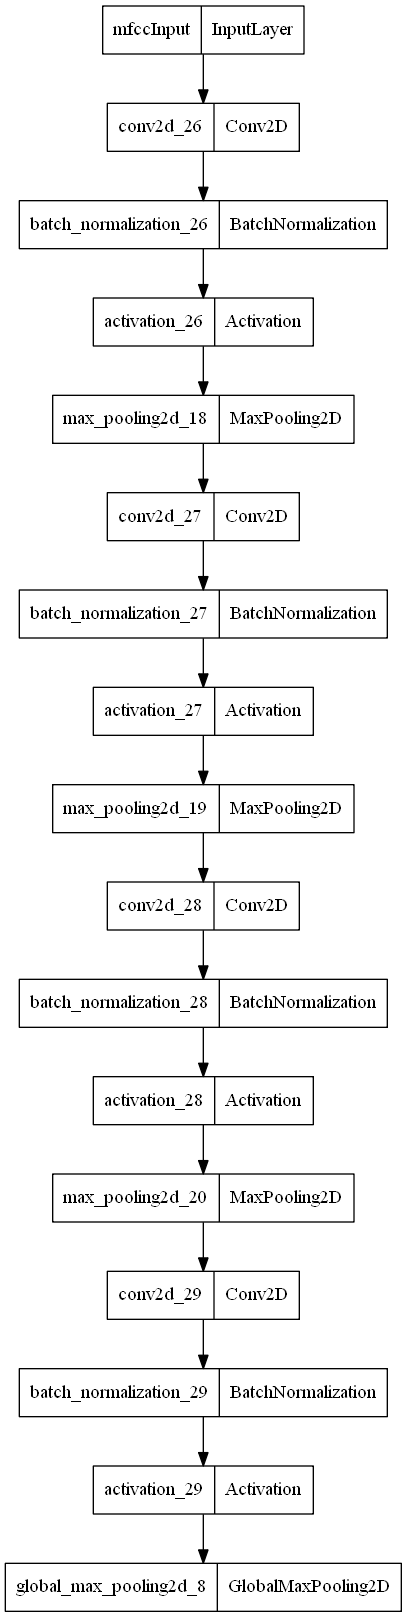

In [10]:
mfcc_input = keras.layers.Input(shape=(20,259,1),name="mfccInput")
x = keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(96,2,padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(128,2,padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
mfcc_output = keras.layers.GlobalMaxPooling2D()(x)

mfcc_model = keras.Model(mfcc_input, mfcc_output, name="mfccModel")

# mfcc_model.summary()
# keras.utils.plot_model(mfcc_model, "mfcc_model.png", show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(mfcc_model, "mfcc_model_2.png")

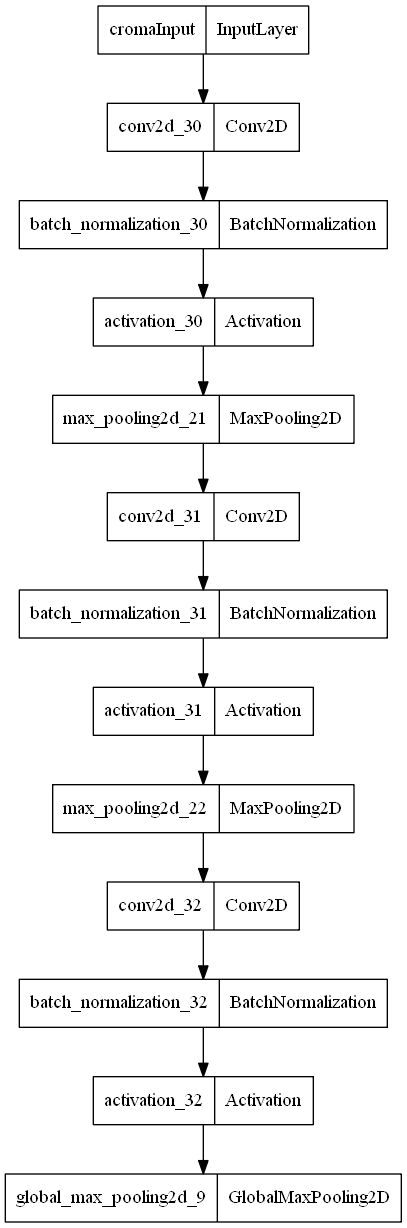

In [11]:
croma_input = keras.layers.Input(shape=(12,259,1),name="cromaInput")
x = keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(128,2,padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
croma_output = keras.layers.GlobalMaxPooling2D()(x)

croma_model = keras.Model(croma_input, croma_output, name="cromaModel")

# croma_model.summary()
# keras.utils.plot_model(croma_model, "croma_model.png", show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(croma_model, "croma_model_2.png")

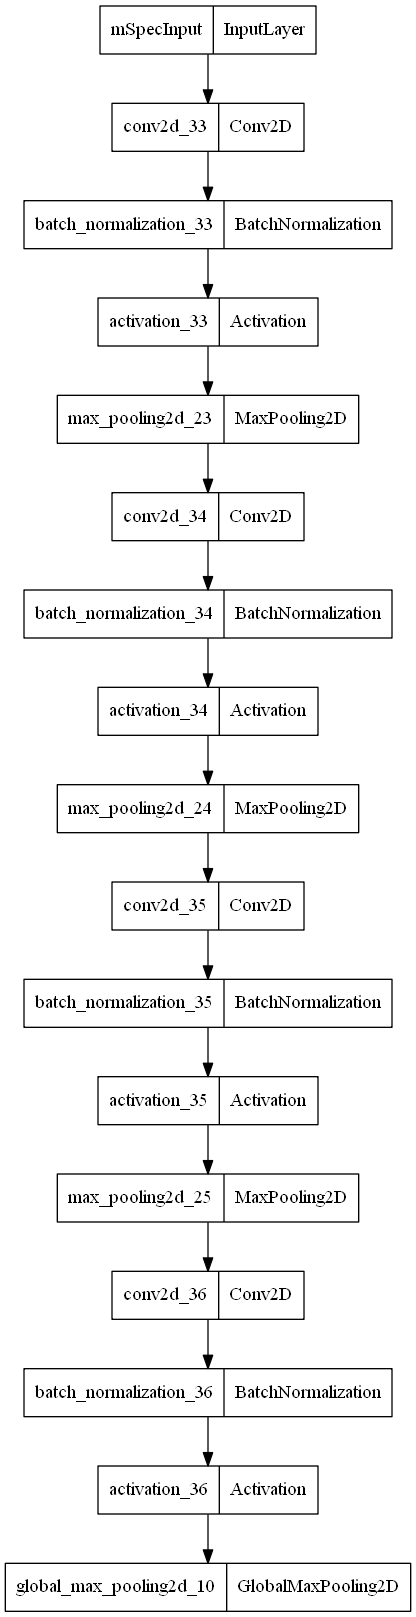

In [12]:
mSpec_input = keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x = keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(96,2,padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x = keras.layers.Conv2D(128,2,padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.activations.relu)(x)
mSpec_output = keras.layers.GlobalMaxPooling2D()(x)

mSpec_model = keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

# mSpec_model.summary()
# keras.utils.plot_model(mSpec_model, "mSpec_model.png", show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(mSpec_model, "mSpec_model_2.png")

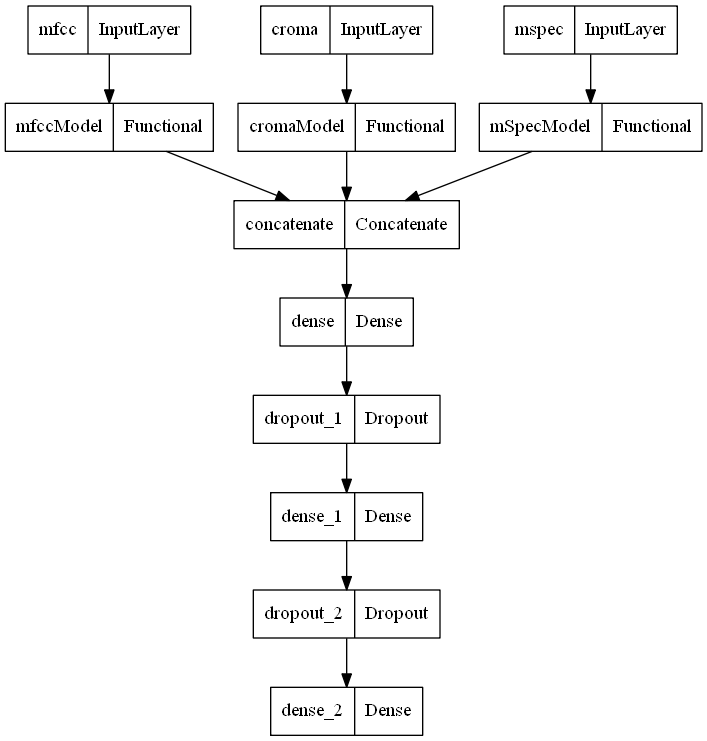

In [13]:
input_mfcc = keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc = mfcc_model(input_mfcc)

input_croma = keras.layers.Input(shape=(12,259,1),name="croma")
croma = croma_model(input_croma)

input_mSpec = keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec = mSpec_model(input_mSpec)

concat = keras.layers.concatenate([mfcc,croma,mSpec])
hidden = keras.layers.Dense(50,activation='relu')(concat)
hidden = keras.layers.Dropout(0.3)(hidden)
hidden = keras.layers.Dense(25,activation='relu')(hidden)
hidden = keras.layers.Dropout(0.3)(hidden)
output = keras.layers.Dense(8,activation='softmax')(hidden)

net = keras.Model([input_mfcc, input_croma, input_mSpec], output, name="Net")

# net.summary()
# keras.utils.plot_model(net, "model.png", show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(net, "model_2.png")

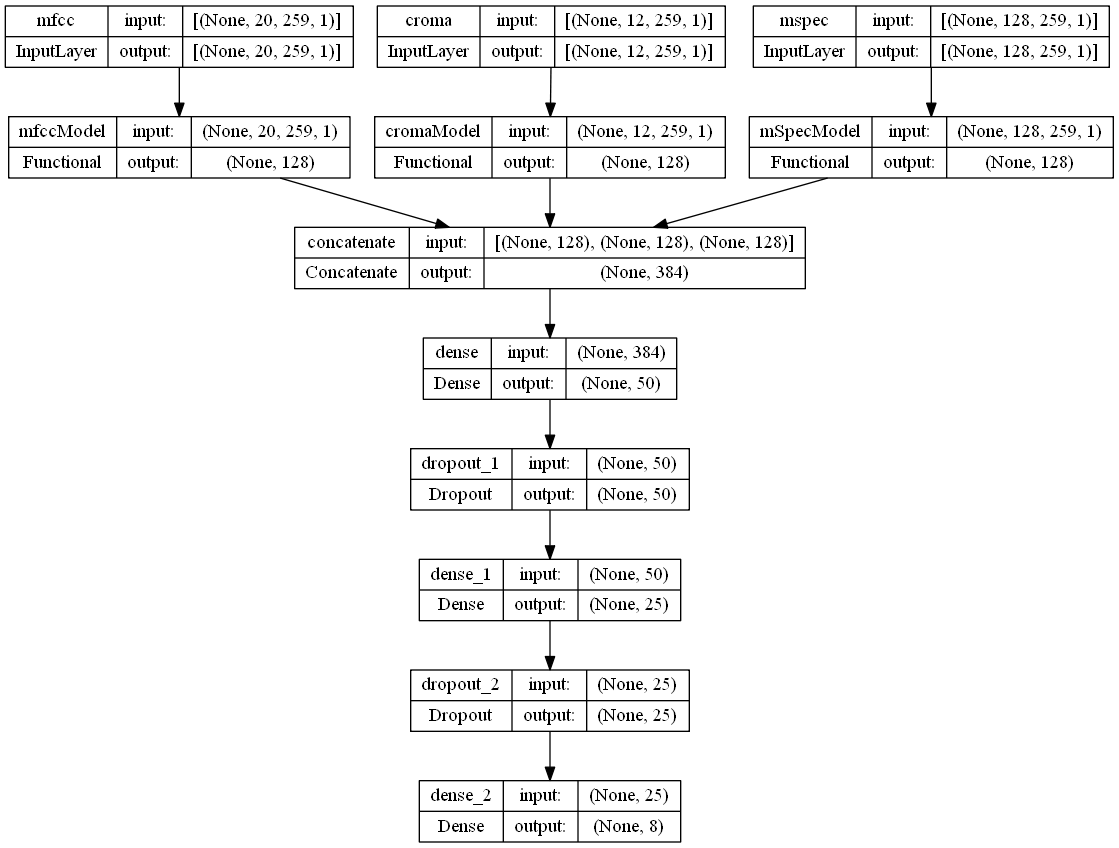

In [14]:
keras.utils.plot_model(net, "model.png", show_shapes=True, show_layer_names=True)

In [46]:
from keras import backend as K
net.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'nadam',
    metrics = ['accuracy']
)
K.set_value(net.optimizer.learning_rate, 0.001)

In [47]:
history = net.fit(
    {"mfcc": mfcc_train,"croma": cstft_train,"mspec": mSpec_train},
    ytrain, batch_size = 100,
    validation_data = ({"mfcc": mfcc_val,"croma": cstft_val,"mspec": mSpec_val}, yval),
    epochs = 100, verbose = 0,
    callbacks = my_callbacks
)

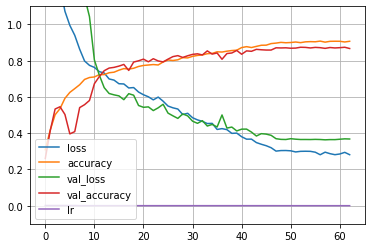

In [48]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [49]:
net.evaluate({"mfcc": mfcc_val,"croma": cstft_val,"mspec": mSpec_val}, yval)

41/41 [==============================] - 1s 11ms/step - loss: 0.3680 - accuracy: 0.8674


[0.3679761588573456, 0.8673862814903259]

## Evaluation

Accuracy: 87%
Loss: 0.3680



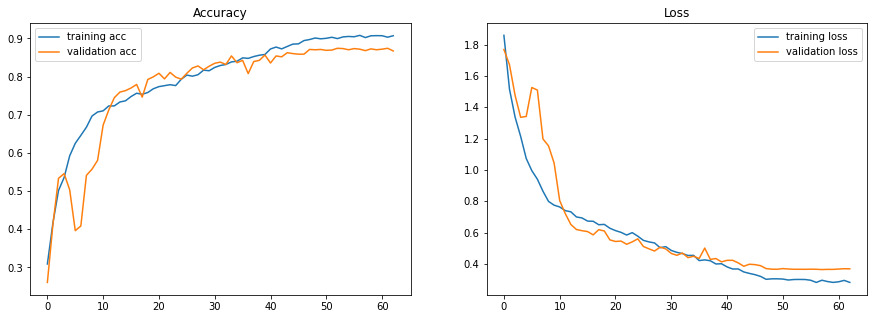

In [54]:
score = net.evaluate({"mfcc": mfcc_val,"croma": cstft_val,"mspec": mSpec_val}, yval, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

41/41 [==============================] - 0s 6ms/step
                precision    recall  f1-score   support

        Asthma       1.00      0.95      0.97        20
Bronchiectasis       0.95      0.95      0.95        63
 Bronchiolitis       0.87      0.81      0.84       160
          COPD       0.98      0.97      0.97       338
       Healthy       0.74      0.72      0.73       193
          LRTI       0.94      0.96      0.95       109
     Pneumonia       0.88      0.86      0.87       171
          URTI       0.75      0.82      0.78       243

      accuracy                           0.87      1297
     macro avg       0.89      0.88      0.88      1297
  weighted avg       0.87      0.87      0.87      1297



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

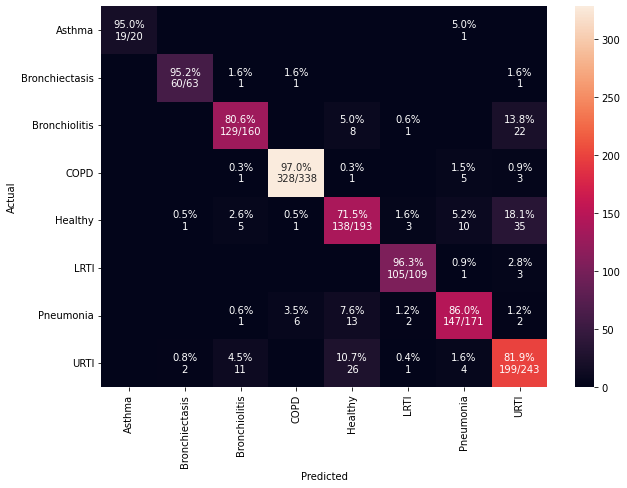

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
matrix_index = list(le.classes_)

preds = net.predict({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val})
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = yval # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

In [56]:
net.save('model_v2.h5')

In [2]:
import pandas as pd
patient_data=pd.read_csv(
    '.\Respiratory_Sound_Database\patient_diagnosis.csv',
    names=['pid','disease']
)

In [5]:
patient_data[patient_data['disease'] == 'Healthy']

,pid,disease
1,102,Healthy
20,121,Healthy
22,123,Healthy
24,125,Healthy
25,126,Healthy
26,127,Healthy
35,136,Healthy
42,143,Healthy
43,144,Healthy
51,152,Healthy


In [3]:
patient_data[patient_data['pid'] == 120]

,pid,disease
19,120,COPD
